In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, BayesianRidge
from lsst.sims.utils import raDec2Hpid, healbin, hpid2RaDec
from lsst.utils import getPackageDir
import os
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
def hp_downgrade(mapin, nside_out=32):
    """
    Let's average down the stellar density maps
    """
    nside_in = hp.npix2nside(np.size(mapin))
    hpid_in = np.arange(np.size(mapin))
    ra, dec = hpid2RaDec(nside_in, hpid_in)
    
    new_map = healbin(ra, dec, mapin, nside=nside_out, reduceFunc=np.mean)
    return new_map

In [3]:
def iqr_sigma(in_array):
    iqr = np.percentile(in_array,75)-np.percentile(in_array,25)
    rms = iqr/1.349 #approximation
    return rms

In [4]:
def running_rms(x_points, y_points, bins=None, binsize=0.5):
    if bins is None:
        bins = np.arange(np.min(x_points), np.max(x_points)+binsize, binsize)
    result = bins*0.
    order = np.argsort(x_points)
    inds = np.searchsorted(x_points[order], bins[1:-1])
    
    result = np.array([iqr_sigma(group) for group in np.split(y_points[order], inds)])
    return result, bins


In [5]:
def gnomonic_project_toxy(RA1, Dec1, RAcen, Deccen):
    """
    Calculate the x/y values of RA1/Dec1 in a gnomonic projection with center at RAcen/Deccen.

    Parameters
    ----------
    RA1 : numpy.ndarray
        RA values of the data to be projected, in radians.
    Dec1 : numpy.ndarray
        Dec values of the data to be projected, in radians.
    RAcen: float
        RA value of the center of the projection, in radians.
    Deccen : float
        Dec value of the center of the projection, in radians.

    Returns
    -------
    numpy.ndarray, numpy.ndarray
        The x/y values of the projected RA1/Dec1 positions.
    """
    cosc = np.sin(Deccen) * np.sin(Dec1) + np.cos(Deccen) * np.cos(Dec1) * np.cos(RA1-RAcen)
    x = np.cos(Dec1) * np.sin(RA1-RAcen) / cosc
    y = (np.cos(Deccen)*np.sin(Dec1) - np.sin(Deccen)*np.cos(Dec1)*np.cos(RA1-RAcen)) / cosc
    return x, y

In [6]:
#ack = np.load('11734_12800_gum_mag_cat.npz')
#ack = np.load('0_1377_gum_mag_cat.npz') # old xargs one
ack = np.load('0_33578_gum_mag_cat.npz')
stars = ack['result_cat'].copy()
ack.close()

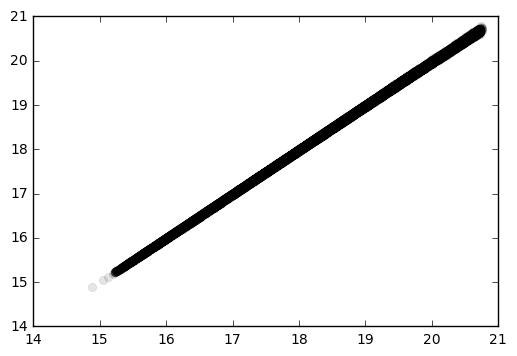

In [7]:
good = np.where(stars['g'] != 0)
plt.plot(stars['g_true'][good], stars['g'][good], 'ko', alpha=.1)

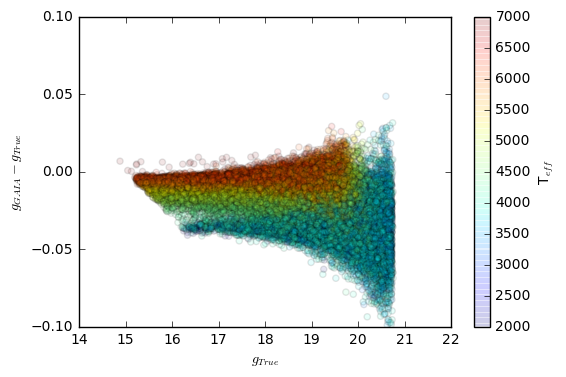

In [8]:
fn = 'g'
good = np.where(stars[fn] != 0)[0]
plt.scatter(stars[fn+'_true'][good], stars[fn][good]-stars[fn+'_true'][good], c=stars['teff'][good], alpha=.1, 
           vmax=7000, vmin=2000)
cb = plt.colorbar()
cb.set_label('T$_{eff}$')
plt.ylim([-.1,.1])
plt.xlabel(r'$%s_{True}$' % fn)
plt.ylabel(r'$%s_{GAIA} - %s_{True}$' % (fn, fn))

In [9]:
print 'number of stars = ', good.size
print 'in g > 17 < 19', np.size(np.where((stars['g_true'][good] > 17.) & (stars['g_true'][good] < 19.))[0])

number of stars =  33578
in g > 17 < 19 13264


(-0.1, 0.1)

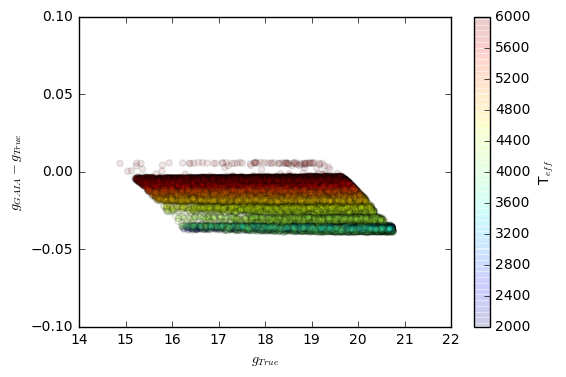

In [10]:
plt.scatter(stars[fn+'_true'][good], stars[fn+'_noiseless'][good]-stars[fn+'_true'][good],
            c=stars['teff'][good], alpha=.1,
           vmin=2000, vmax=6000)
plt.xlabel('$'+fn+'_{True}$')
plt.ylabel('$'+fn+'_{GAIA}-'+fn+'_{True}$')
cb = plt.colorbar()
cb.set_label('T$_{eff}$')
plt.ylim([-.1,.1])

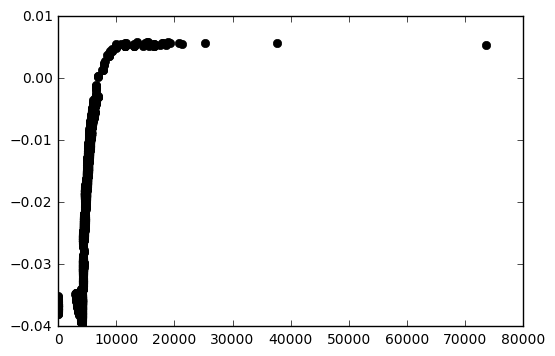

In [11]:
plt.plot(stars['teff'][good], stars[fn+'_noiseless'][good]-stars[fn+'_true'][good], 'ko')

In [12]:
# Make a correction so now only the random noise is left.
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    diff = stars[fn+'_noiseless'][good]-stars[fn+'_true'][good]
    stars[fn][good] -= diff

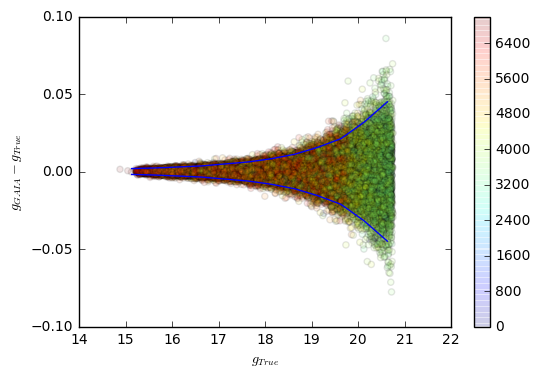

In [13]:
fn = 'g'
plt.scatter(stars[fn+'_true'][good], stars[fn][good]-stars[fn+'_true'][good], c=stars['teff'][good], alpha=.1, vmax=7000)
cb = plt.colorbar()
cb.set_clim([0, 7000])
plt.ylim([-.1,.1])
plt.xlabel(r'$%s_{True}$' % fn)
plt.ylabel(r'$%s_{GAIA} - %s_{True}$' % (fn, fn))
running, bins = running_rms(stars[fn+'_true'][good], stars[fn][good]-stars[fn+'_true'][good])
plt.plot((bins[:-1]+bins[1:])/2., 2.*running, 'b')
plt.plot((bins[:-1]+bins[1:])/2., -2*running, 'b')

In [14]:
running

array([ 0.00094446,  0.00114042,  0.00145709,  0.00179282,  0.00243153,
        0.00306809,  0.00410267,  0.00554471,  0.0077813 ,  0.01057797,
        0.01592019,  0.02246974])

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


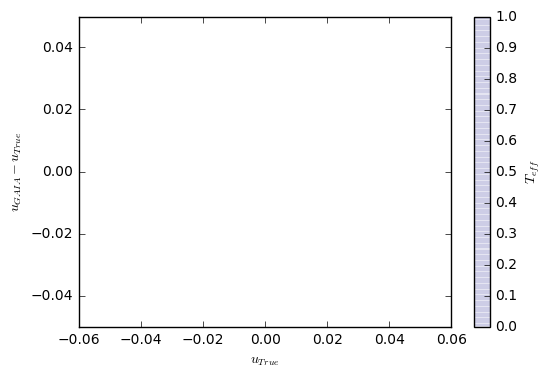

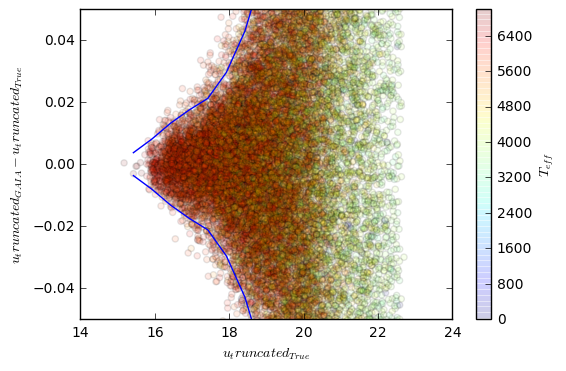

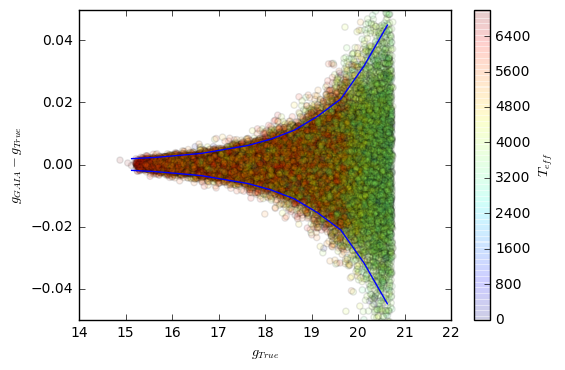

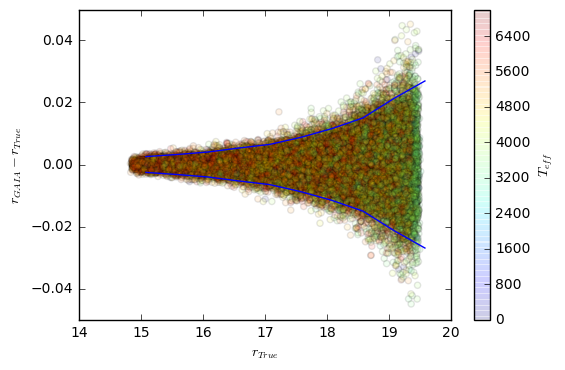

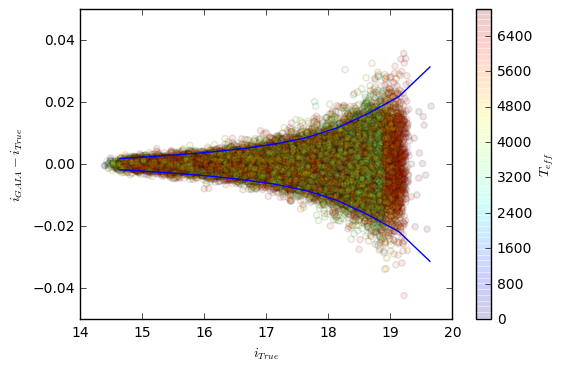

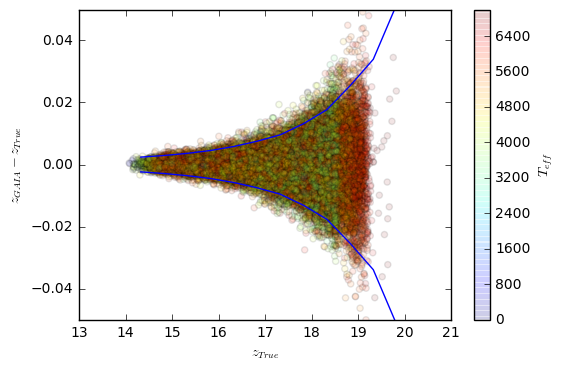

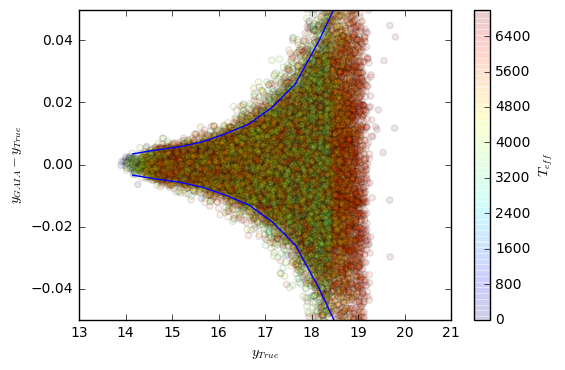

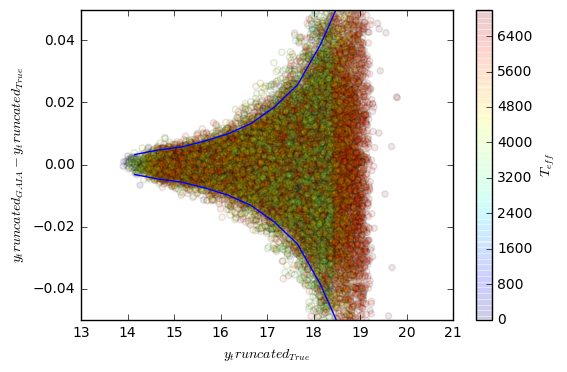

In [15]:
for fn in filters:
    plt.figure()
    plt.scatter(stars[fn+'_true'][good], stars[fn][good]-stars[fn+'_true'][good], c=stars['teff'][good], alpha=.1, vmax=7000)
    cb = plt.colorbar()
    cb.set_clim([0, 7000])
    cb.set_label(r'$T_{eff}$')
    plt.ylim([-.05,.05])
    plt.xlabel(r'$%s_{True}$' % fn)
    plt.ylabel(r'$%s_{GAIA} - %s_{True}$' % (fn, fn))
    running, bins = running_rms(stars[fn+'_true'][good], stars[fn][good]-stars[fn+'_true'][good])
    plt.plot((bins[:-1]+bins[1:])/2., 2.*running, 'b')
    plt.plot((bins[:-1]+bins[1:])/2., -2*running, 'b')
    plt.savefig('Plots/%s_resids.png' % fn)

In [16]:
mapDir = os.path.join(getPackageDir('sims_maps'),'StarMaps')



In [17]:
data = np.load(os.path.join(mapDir,'starDensity_%s_nside_64.npz' % 'u'))
starDensity = data['starDensity'].copy()
hp_bins=data['bins'].copy()
data.close()


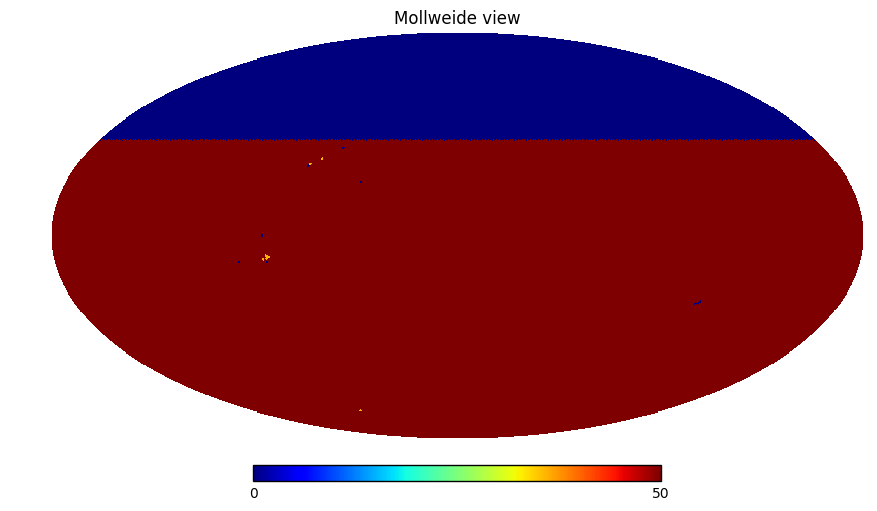

In [18]:
hp.mollview(starDensity[:,30], max=50)

In [19]:
print starDensity.shape[0]
print hp.npix2nside(starDensity.shape[0])
hp.nside2pixarea(hp.npix2nside(starDensity.shape[0]), degrees=True)

49152
64


0.83929364521116678

billions of stars in filter g = 0.055096


/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in divide


billions of stars in filter r = 0.090041
billions of stars in filter i = 0.120814
billions of stars in filter z = 0.152898
billions of stars in filter y = 0.178107


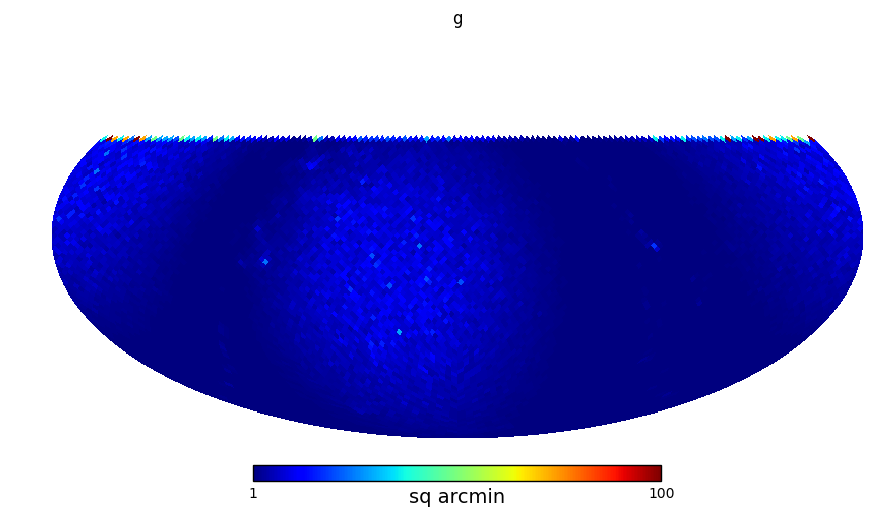

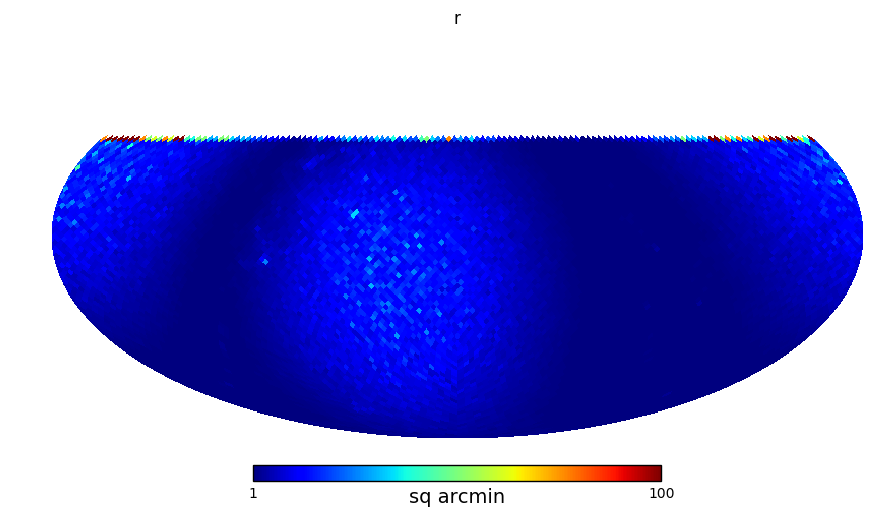

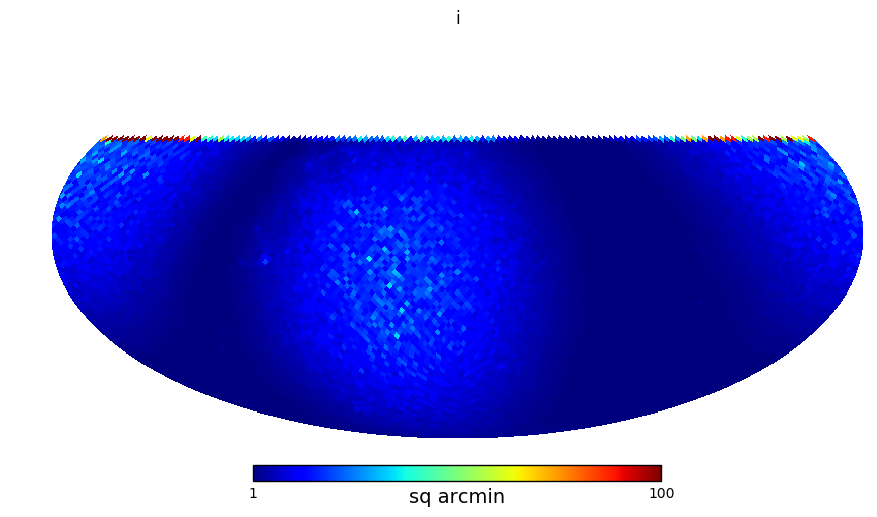

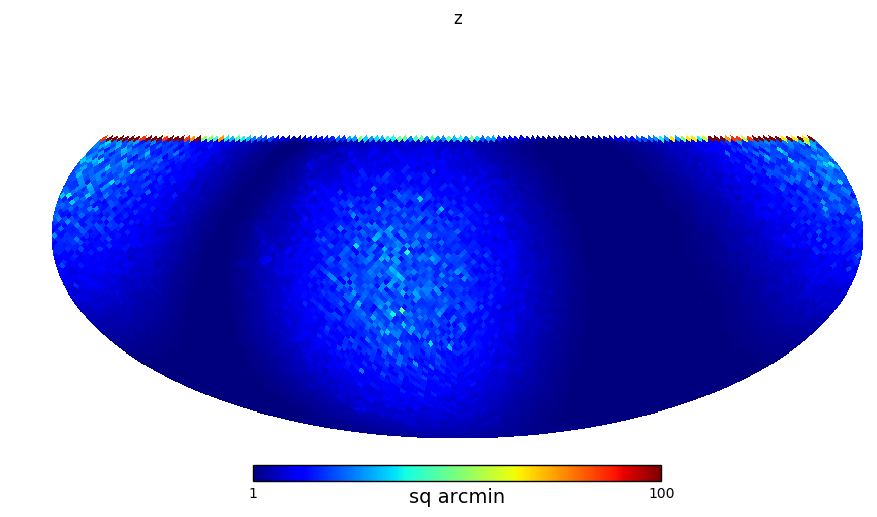

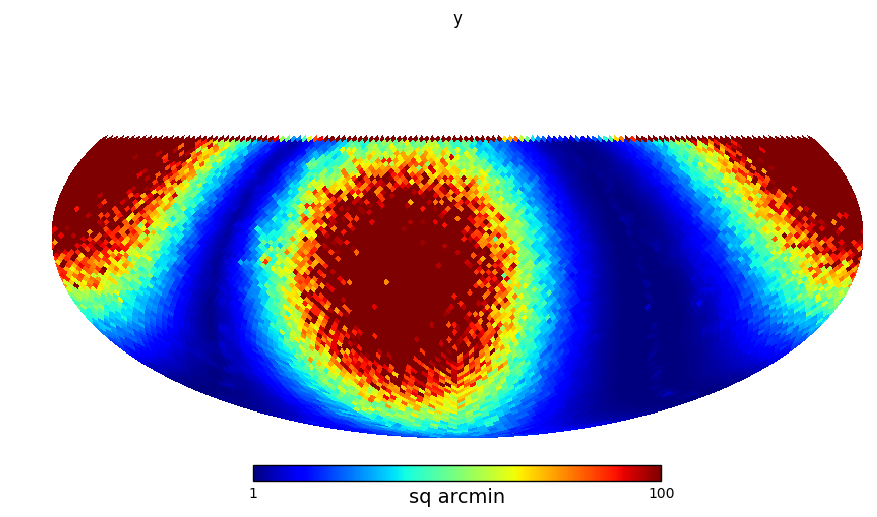

In [20]:
# Now to 
f_o_v_sq_deg = 3.0e9*0.2**2/(60.**2)/(60.**2)
goal_err = 0.005
mag_range = [17., 18.]
# find the area needed to get to the goal area
for fn in ['g', 'r', 'i', 'z', 'y']:# filters:
    running, bins = running_rms(stars[fn+'_true'][good], stars[fn][good]-stars[fn+'_true'][good])
    n_stars, bins = np.histogram(stars[fn+'_true'][good], bins=bins)
    gbins = np.where((bins >= np.min(mag_range)) & (bins <= np.max(mag_range)))[0]
    err_sq = running[gbins]**2/n_stars[gbins]
    frac_stars_needed = 1./np.sum(n_stars[gbins]/running[gbins]**2)/goal_err**2
    area_needed_sq_arcmin = f_o_v_sq_deg*frac_stars_needed * 60.**2
    
    data = np.load(os.path.join(mapDir,'starDensity_%s_nside_64.npz' % fn))
    # Cumulative number counts, units of stars/sq deg. Array at healpix locations
    starDensity = data['starDensity'].copy()
    # magnitude bins 
    hp_bins=data['bins'].copy()
    # pixels where there were so many stars some were skipped
    mask = data['overMaxMask']
    data.close()
    nside = hp.npix2nside(starDensity[:,0].size)
    ra_gums = stars['raj2000'].mean()
    dec_gums = stars['dej2000'].mean()
    gums_hp = raDec2Hpid(nside, ra_gums, dec_gums)
    gbins = np.where((hp_bins >= np.min(mag_range)) & (hp_bins <= np.max(mag_range)))[0]
    starDensity = starDensity[:,np.max(gbins)] - starDensity[:,np.min(gbins)]
    print 'billions of stars in filter %s = %f' % (fn, 1e-9*np.sum(starDensity*hp.nside2pixarea(nside, degrees=True)))
    gums_density = starDensity[gums_hp]
    starDensity = hp_downgrade(starDensity)
    
    area_needed_map = area_needed_sq_arcmin/starDensity*gums_density
    hp.mollview(area_needed_map, unit='sq arcmin', title=fn, min=1, max=100)
    
    plt.savefig('Plots/area_needed_%s.png' % fn)

In [21]:
# for reference, one chip is 176 sq arcmin. so Gaia gives plenty of stars 
area_needed_sq_arcmin

25.549697377128769

In [22]:
area_needed_map.shape

(12288,)

In [23]:
gbins

array([11, 12, 13, 14, 15])

In [24]:

#starDensity = np.sum(starDensity, axis=1)
#print starDensity.shape
#starDensity = starDensity/starDensity[gums_hp]
#hp.mollview(starDensity, min=.5, max=2)

In [25]:
#np.sum(starDensity, axis=1).shape

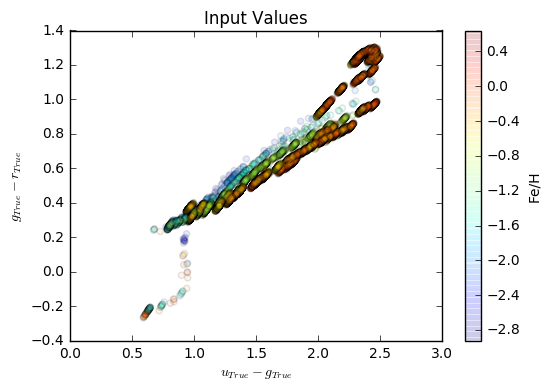

In [26]:
# Let's see how hard it would be to recover u
plt.scatter(stars['u_true'][good] - stars['g_true'][good], stars['g_true'][good]-stars['r_true'][good], 
            alpha=.1, c=stars['feH'][good])
cb = plt.colorbar()
cb.set_label('Fe/H')
plt.title('Input Values')
plt.xlabel(r'$u_{True} - g_{True}$')
plt.ylabel(r'$g_{True} - r_{True}$')


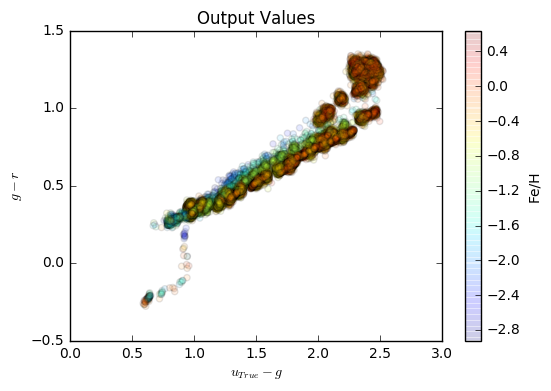

In [27]:
plt.scatter(stars['u_true'][good] - stars['g'][good], stars['g'][good]-stars['r'][good], 
            alpha=.1, c=stars['feH'][good])
cb = plt.colorbar()
cb.set_label('Fe/H')
plt.title('Output Values')
plt.xlabel(r'$u_{True} - g$')
plt.ylabel(r'$g - r$')


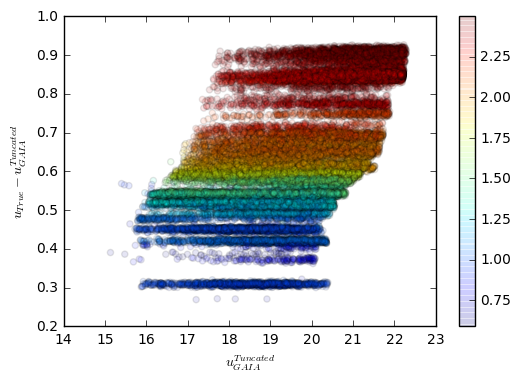

In [28]:
good = np.where((stars['g'] != 0) & (stars['u_truncated'] > 5))
#good = np.where( (stars['u_true']-stars['g_true'] < 2.0)  & (stars['u_true']-stars['g_true'] > 1.4))
plt.scatter(stars['u_truncated_noiseless'][good] , 
         stars['u_true'][good] - stars['u_truncated_noiseless'][good],
            c=stars['u_true'][good]-stars['g_true'][good], alpha=.1)
plt.xlabel('$u^{Tuncated}_{GAIA}$')
plt.ylabel('$u_{True}-u^{Tuncated}_{GAIA}$')
plt.colorbar()

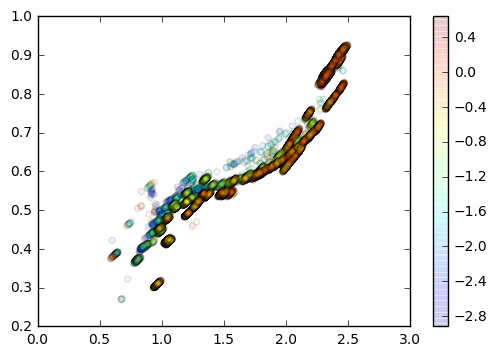

In [29]:
plt.scatter(stars['u_true'][good]-stars['g_true'][good], 
            stars['u_true'][good] - stars['u_truncated_noiseless'][good], 
            c=stars['feH'][good], alpha=.1)
plt.colorbar()

In [30]:

ytrain = stars['u_true'][good]
xtrain = np.zeros((ytrain.size, 4), dtype=float)
xtrain[:,0] = stars['u_truncated_noiseless'][good]
xtrain[:,1] = stars['g_true'][good]-stars['r_true'][good]
xtrain[:,2] = stars['r_true'][good]-stars['i_true'][good]
xtrain[:,3] = stars['i_true'][good]-stars['z_true'][good]

In [31]:

model = BayesianRidge()#LinearRegression() #GaussianNB()

model.fit(xtrain, ytrain)


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [32]:
newx = np.zeros((ytrain.size, 4), dtype=float)
newx[:,0] = stars['u_truncated'][good]
newx[:,1] = stars['g'][good] - stars['r'][good]
newx[:,2] = stars['r'][good]-stars['i'][good]
newx[:,2] = stars['i'][good]-stars['z'][good]
stars['u'][good] = model.predict(newx)

(-0.5, 0.5)

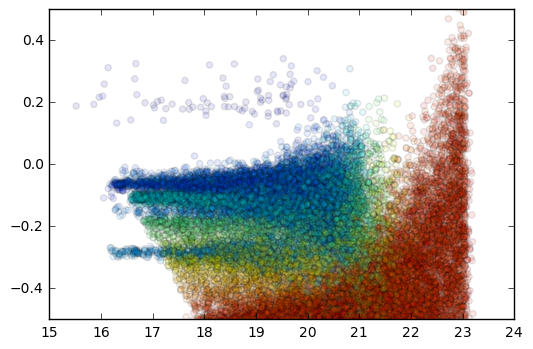

In [33]:
plt.scatter(stars['u_true'][good], stars['u_true'][good] - stars['u'][good], 
            c=stars['u_truncated_true'][good] - stars['g_true'][good], alpha=.1)
plt.ylim([-.5,.5])

In [34]:
# Let's just project down to x-y, and run a weighted mean filter. Maybe I could just use hexbin.
x,y = gnomonic_project_toxy(np.radians(stars['raj2000']), np.radians(stars['dej2000']), 
                      np.radians(340.), np.radians(27.5))

In [35]:
x = np.degrees(x)
y = np.degrees(y)

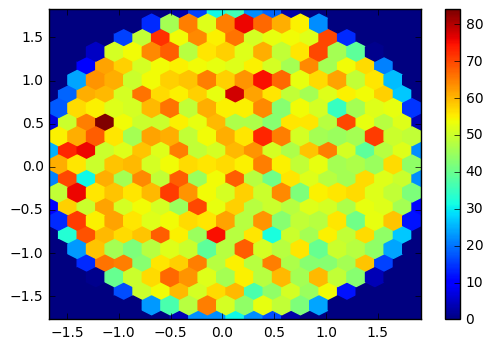

In [36]:
filtername = 'r'
good =np.where((stars[filtername] > 17) & (stars[filtername] < 19))
plt.hexbin(x[good], y[good], gridsize=20)
plt.colorbar()

In [37]:
c = SkyCoord("galactic", l=0*u.deg, b=-90*u.deg)
c.icrs.ra.deg, c.icrs.dec.deg
#pole_hp = 

(12.85947789477605, -27.128252414968006)

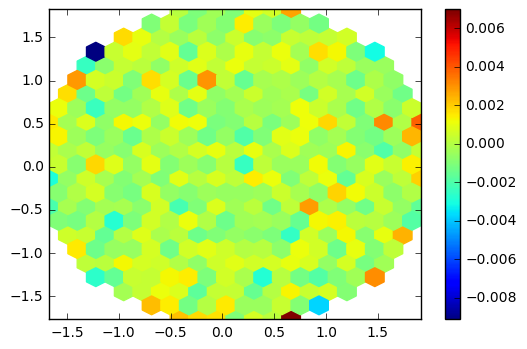

In [38]:
plt.hexbin(x[good], y[good], gridsize=20, 
           C=stars[filtername][good]-stars[filtername+'_true'][good], 
           reduce_C_function=np.median)
plt.colorbar()

In [39]:
# Now need to decide what this would look like at the galactic pole
ra_gums = stars['raj2000'].mean()
dec_gums = stars['dej2000'].mean()
print ra_gums, dec_gums
print stars['raj2000'].size
mapDir = os.path.join(getPackageDir('sims_maps'),'StarMaps')

data = np.load(os.path.join(mapDir,'starDensity_%s_nside_64.npz' % 'g'))
# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = data['starDensity'].copy()
# magnitude bins 
bins=data['bins'].copy()
# pixels where there were so many stars some were skipped
mask = data['overMaxMask']
data.close()
nside = hp.npix2nside(starDensity[:,0].size)


340.103660422 27.5473739403
33578


In [40]:

gums_hp = raDec2Hpid(nside, ra_gums, dec_gums)
pole_hp = raDec2Hpid(nside, c.icrs.ra.deg, c.icrs.dec.deg)


In [41]:
starDensity.dtype

dtype('float64')

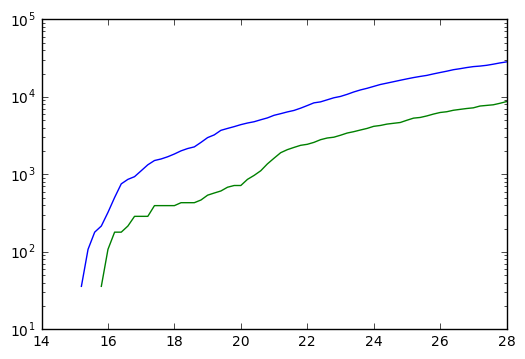

In [42]:
plt.semilogy(bins[1:], starDensity[gums_hp,:])
plt.plot(bins[1:], starDensity[pole_hp,:])

In [43]:
mag_point = np.where((bins > 17.4) & (bins < 17.6))[0]
star_ratio = starDensity[pole_hp,mag_point]/starDensity[gums_hp,mag_point]
star_ratio

array([ 0.23404255])

In [44]:
# How many stars between 17 and 20 do I expect on a chip at the pole?
sd = starDensity[pole_hp,np.where(bins <=20)[0].max()] - starDensity[pole_hp,np.where(bins <=17)[0].max()]
# area of CCD = 4000 pix * 0.2 arcsec
area = (4000*.2)**2./(3600.**2)
stars_per_ccd = sd*area
stars_per_ccd

28.444444444444443

In [45]:
# GAIA says it will get a maximum density of 750,000 stars/deg^2. I should be able to convert that to a limiting depth on the plane


In [46]:
#good = np.where( (stars[fn+'_true'] > 16.8) & (stars[fn+'_true']< 17.2) & (stars[fn]>0))
good = np.where( (stars[fn+'_true'] > 17.8) & (stars[fn+'_true']< 18.2) & (stars[fn]>0))
resid = stars[fn][good]-stars[fn+'_true'][good]
print np.std(resid), good[0].size, np.std(resid)/((float(good[0].size)/189.)**.5)

0.0178238575658 5464 0.00331495211793


In [47]:
stars['id'][np.where((stars['g_true'] < 16) & (stars['g'] > 19))]
np.where((stars['g_true'] < 16) & (stars['g'] > 19))

(array([], dtype=int64),)

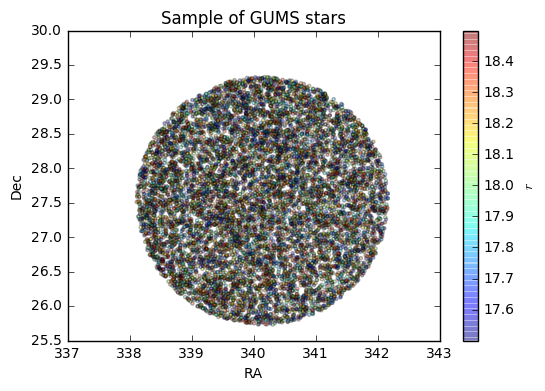

In [48]:
ack = np.where((stars['r_true'] < 18.5) & (stars['r_true'] > 17.5))
plt.scatter(stars['raj2000'][ack], stars['dej2000'][ack], c=stars['r_true'][ack], alpha=.3, s=5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('Sample of GUMS stars')
cb = plt.colorbar()
cb.set_label(r'$r$')
plt.savefig('Plots/fov.png')

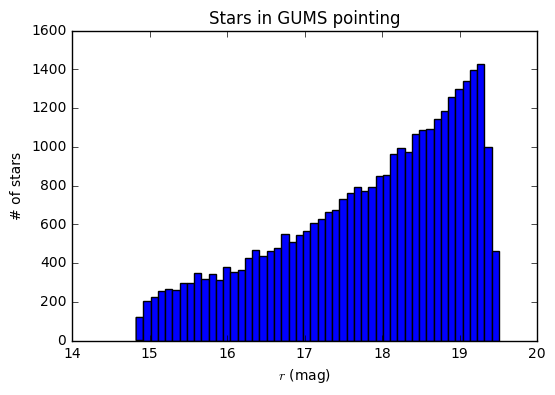

In [49]:
plt.hist(stars['r_true'], bins=50)
plt.xlabel(r'$r$ (mag)')
plt.ylabel('# of stars')
plt.title('Stars in GUMS pointing')
plt.savefig('Plots/star_mag_hist.png')

In [50]:
stars.size
good = np.where((stars['g'] > 17) & (stars['g'] < 20))[0]
good.size/189.

122.46560846560847

In [51]:
from lsst.sims.utils import angularSeparation
ra_pole = np.median(stars['raj2000'])
dec_pole = np.median(stars['dej2000'])
dist_to_center = angularSeparation(ra_pole, dec_pole, stars['raj2000'], stars['dej2000'])

In [52]:
dist_to_center.max()

1.8512650688331074

In [53]:
from gaia_spec import gen_gums_mag_cat

In [54]:
iid = 58 #11733
star, sed, observed_sed = gen_gums_mag_cat(istart=iid, nstars=2, workdir='ack', save=False)

clipped 1466473 entries. 33578 remain.
using 33578 stars from GAIA

Opening cache of LSST SEDs in:
/Users/yoachim/gitRepos/sims_photutils/cacheDir/lsst_sed_cache_2.p


/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:1493: UserWarning: Multiple close files
  warnings.warn('Multiple close files')
gaia_spec.py:420: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  observed_sed = ulysses2SED(data=gaia_observed, response=responses[tmatch])
/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:746: UserWarning: There is an area of non-overlap between desired wavelength range  (306.64 to 1238.64)and sed FromArray (581.50 to 1238.17)
  + 'and sed %s (%.2f to %.2f)' % (self.name, wavelen.min(), wavelen.max()))
gaia_spec.py:174: RuntimeWarning: invalid value encountered in divide
  flambda = (red_sed.flambda*red_weight + blue_sed.flambda*blue_weight) / (red_weight + blue_weight)
/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:746: UserWarning: There is an area of non-overlap between desired wavelength range  (305.40 to 408.50)and 

In [55]:
i=0
print star['id']
fn = ['u_truncated', 'g', 'r', 'i', 'z', 'y']
for filn in fn:
    print star[i][filn], star[i][filn+'_true']

[58 59]
22.4618279556 22.1110926862
20.2060198848 20.25877562
19.0447462656 19.0167770742
18.4334148162 18.4286460095
18.1512495562 18.1307168147
17.9922920985 17.966151823


In [56]:
i=58
print stars[i]['id']
for filn in fn:
    print stars[i][filn], stars[i][filn+'_true']

58
22.1607612642 22.1110926862
20.2884363146 20.25877562
19.0084175892 19.0167770742
18.4390707007 18.4286460095
18.1389173305 18.1307168147
17.9505407683 17.966151823


(300, 10000)

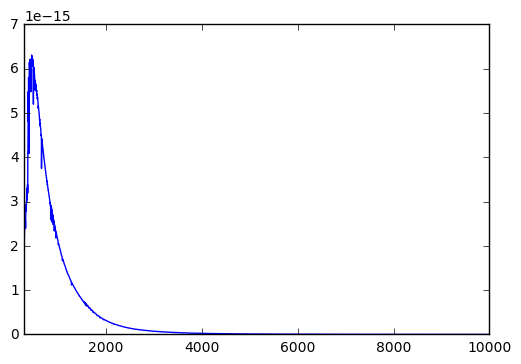

In [57]:
plt.plot(sed.wavelen, sed.flambda)
#plt.plot(observed_sed.wavelen, observed_sed.flambda)
plt.xlim([300,10000])

(300, 1000)

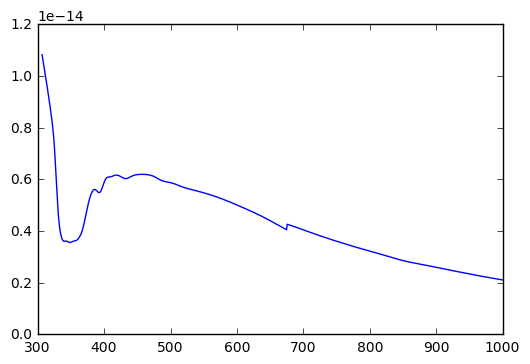

In [58]:
plt.plot(observed_sed.wavelen, observed_sed.flambda)
plt.xlim([300,1000])

In [59]:
from gaia_spec import SED2GAIA
gaia_observed = SED2GAIA(sed)

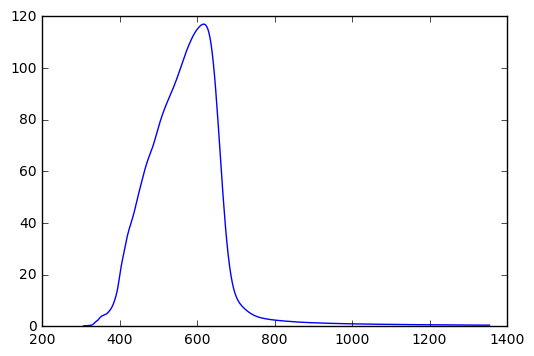

In [60]:
plt.plot(gaia_observed['BP_wave'], gaia_observed['noiseFreeSpec']['BPNoiseFreeSpec'])

In [61]:
gaia_observed.keys()

['noisySpec', 'noiseFreeSpec', 'BP_wave', 'RP_wave']